In [1]:
%matplotlib widget

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

import diabayes as db
from diabayes.forward_models import Forward, rsf, ageing_law, springblock
from diabayes.solver import ODESolver

In this example, we will be running a simple forward simulation of a non-inertial spring-block governed by classical rate-and-state friction (RSF). The forward simulation serves as a set of "friction observations" that we will then invert for the rate-and-state parameters ($a,b,D_c$). If everything goes well, the inverted parameters are identical to the ones we started with.

## 1. Forward modelling

First we define the RSF and spring-block parameters, and assume that we start at steady-state:

In [3]:
# RSF parameters
a = 0.01
b = 0.9 * a
Dc = 1e-5

# Spring-block parameters: stiffness, initial velocity, final velocity
k = 1e3
v0 = 1e-6
v1 = 1e-5

# Initial friction and state
mu0 = 0.6
theta0 = Dc / v0

Next, we describe our forward model, which is composed of a friction law (classical RSF), a state evolution law (ageing law), and the stress transfer model (non-inertial spring-block). We also define the solver, which includes both the forward and inverse solver routines.

In [4]:
forward = Forward(friction_model=rsf, state_evolution=ageing_law, block_type=springblock)
solver = ODESolver(forward_model=forward)

The last step before running a forward simulation, is to pack all of the parameters and initial conditions into appropriate "containers". These containers act like `namedtuple`s; you can initialise one by providing the parameters in the right order, or as keyword arguments (for example, `params = db.RSFParams(a, b, Dc)` returns the same as `params = db.RSFParams(Dc=Dc, a=a, b=b)`). You can access individual entries by their name, e.g. `b = params.b`.

In [5]:
# Initial values of friction and state
y0 = db.Variables(mu=mu0, state=theta0)
# RSF parameters
params = db.RSFParams(a=a, b=b, Dc=Dc)
# RSF constants
constants = db.RSFConstants(v0=v0, mu0=mu0)
# Spring-block constants
block_constants = db.SpringBlockConstants(k=k, v_lp=v1)

# The time samples for which we want a solution
t = jnp.linspace(0, 15., 1000)

# Run the forward simulation
result = solver.solve_forward(
    t, y0, params=params,
    friction_constants=constants,
    block_constants=block_constants
)

The result of this forward simulation (`result`) is a `db.Variables` object similar to `y0` defined above. Hence the friction and state can be accessed as `result.ys.mu` and `result.ys.state`:

Text(0.5, 0, 'time [s]')

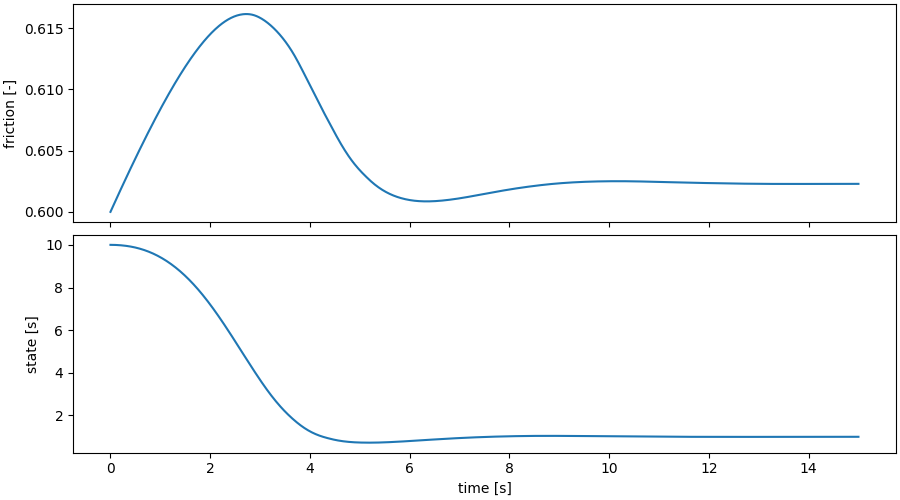

In [6]:
mu = result.mu
theta = result.state

plt.close("all")
fig, axes = plt.subplots(nrows=2, figsize=(9, 5), constrained_layout=True, sharex="all")
axes[0].plot(t, mu)
axes[0].set_ylabel("friction [-]")
axes[1].plot(t, theta)
axes[1].set_ylabel("state [s]")
axes[1].set_xlabel("time [s]")

## 2. Maximum-likelihood inversion

Now that we have some "measurements" of a friction coefficient, we can try to invert for the underlying parameters that govern the dynamics. For this particular toy example it is not super useful to invert for the parameters that you already know, but in reality you would replace `mu` with your laboratory measurements, for which the RSF parameters are not known.

To start simple, we begin with a _maximum-likelihood_ inversion, which tries to find a (local) minimum in the misfit between the measured and predicted friction values. The parameters that correspond with the best fit may not be unique (there could be multiple combinations of parameters that yield the same misfit), and this kind of inversion does not offer a good sense of the uncertainties and trade-offs in the inverted parameters. For this we'd need to do a _Bayesian inversion_, which will come a bit later. Regardless, the maximum likelihood inversion gives us a good starting point, and might already be sufficient for some applications.

In the cell below, we generate simulate noisy measurements by adding some Gaussian noise to the friction curve obtained above. We also define an initial guess of the RSF parameters that is a bit different from the true parameter values, which in practice is likely to be the case.

In [7]:
import jax.random as jr

# The JAX random number generator
key = jr.PRNGKey(42)
key, split_key = jr.split(key)
noise = jr.normal(split_key, shape=(len(t),))

# You can play around with the noise amplitude to make
# the inversion more or less challenging...
noise_amplitude = 1e-3

mu_measured = mu + noise * noise_amplitude

# Initial guess of the parameters
params_guess = db.RSFParams(
    a = 1.1 * a,
    b = 1.2 * b,
    Dc = 5 * Dc
)

# Do the maximum-likelihood inversion
# Set verbose=True to get intermediate messages
# of the solver progress
inv_result = solver.max_likelihood_inversion(
    t, mu_measured,
    params=params_guess,
    friction_constants=constants,
    block_constants=block_constants,
    verbose=True
)

Step: 0, Loss on this step: 0.05701778953668869
Step: 1, Loss on this step: 0.008426669395963007
Step: 2, Loss on this step: 0.04533961434363544
Step: 3, Loss on this step: 0.04219218180410471
Step: 4, Loss on this step: 0.04089619022651131
Step: 5, Loss on this step: 0.05387010819163528
Step: 6, Loss on this step: 0.12880864148248167
Step: 7, Loss on this step: 0.005859894402973482
Step: 8, Loss on this step: 0.0036073091782483696
Step: 9, Loss on this step: 0.0029065271595560523
Step: 10, Loss on this step: 0.00232008817640738
Step: 11, Loss on this step: 0.0019266369568930897
Step: 12, Loss on this step: 0.0015456980054288673
Step: 13, Loss on this step: 0.0012871461506268778
Step: 14, Loss on this step: 0.0010871856614614634
Step: 15, Loss on this step: 0.0009450841274790639
Step: 16, Loss on this step: 0.0008377017682057023
Step: 17, Loss on this step: 0.0006440217127184301
Step: 18, Loss on this step: 0.0005527392653225283
Step: 19, Loss on this step: 0.0004820365076114968
Step: 

The result of the inversion (`inv_result`) is an [`optimistix.Solution`](https://docs.kidger.site/optimistix/api/solution/#optimistix.Solution) object, similar to the `diffrax.Solution` object we've seen before. The inverted parameters are accessed through `inv_result.value`, which contains a `RSFParams` object.

We can get these parameters and run another forward simulation to see if we obtained an acceptable fit with the data:

Inverted parameters: RSFParams(a=Array(0.00986196, dtype=float64), b=Array(0.00886787, dtype=float64), Dc=Array(1.04567191e-05, dtype=float64))
True parameters: RSFParams(a=0.01, b=0.009000000000000001, Dc=1e-05)


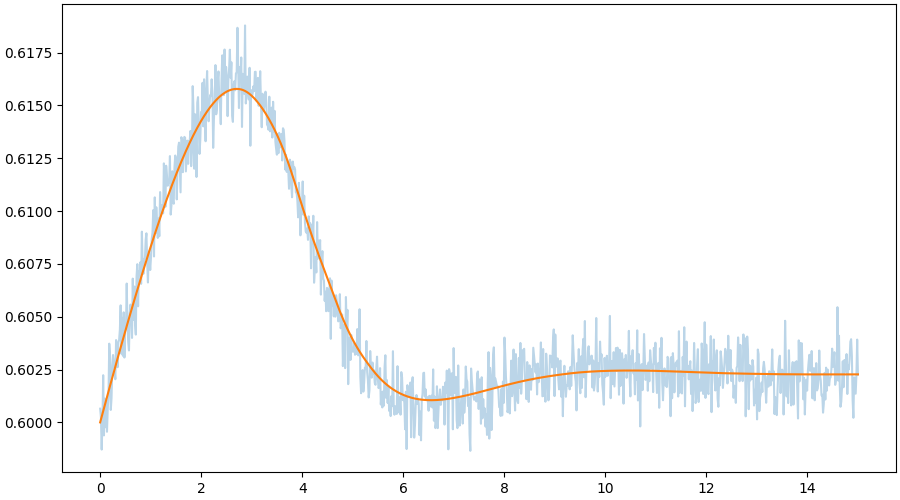

In [8]:
params_inv = inv_result.value

result_predicted = solver.solve_forward(t, y0, params_inv, constants, block_constants)

print(f"Inverted parameters: {params_inv}")
print(f"True parameters: {params}")

plt.close("all")
fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)
ax.plot(t, mu_measured, alpha=0.3)
ax.plot(t, result_predicted.mu)

As you can see, even with a substantial noise level we were able to recover the true parameters. We can do the inversion again with a different initial guess to see how much this starting point affects the solver convergence:

In [9]:
params_guess2 = db.RSFParams(
    a = 0.9 * a,
    b = 0.5 * b,
    Dc = 2 * Dc
)

inv_result2 = solver.max_likelihood_inversion(
    t, mu_measured,
    params=params_guess2,
    friction_constants=constants,
    block_constants=block_constants,
    verbose=True
)

params_inv2 = inv_result2.value
result_predicted2 = solver.solve_forward(t, y0, params_inv2, constants, block_constants)

Step: 0, Loss on this step: 0.037112978439809007
Step: 1, Loss on this step: 0.008446597639457603
Step: 2, Loss on this step: 0.011230654700420253
Step: 3, Loss on this step: 0.010351276459970582
Step: 4, Loss on this step: 0.00805469116699875
Step: 5, Loss on this step: 0.007736147358686476
Step: 6, Loss on this step: 0.5659830665660537
Step: 7, Loss on this step: 0.8313167481375603
Step: 8, Loss on this step: 0.011655851340145167
Step: 9, Loss on this step: 0.004206803455487899
Step: 10, Loss on this step: 0.0018982842003712366
Step: 11, Loss on this step: 0.0015535046629491392
Step: 12, Loss on this step: 0.001263024993119862
Step: 13, Loss on this step: 0.0010727452050579983
Step: 14, Loss on this step: 0.0009311492053747009
Step: 15, Loss on this step: 0.0008275058544759351
Step: 16, Loss on this step: 0.000748352946798722
Step: 17, Loss on this step: 0.000602385717104706
Step: 18, Loss on this step: 0.0004903515239977218
Step: 19, Loss on this step: 0.00046783355546733746
Step: 2

Visual inspection of the results:

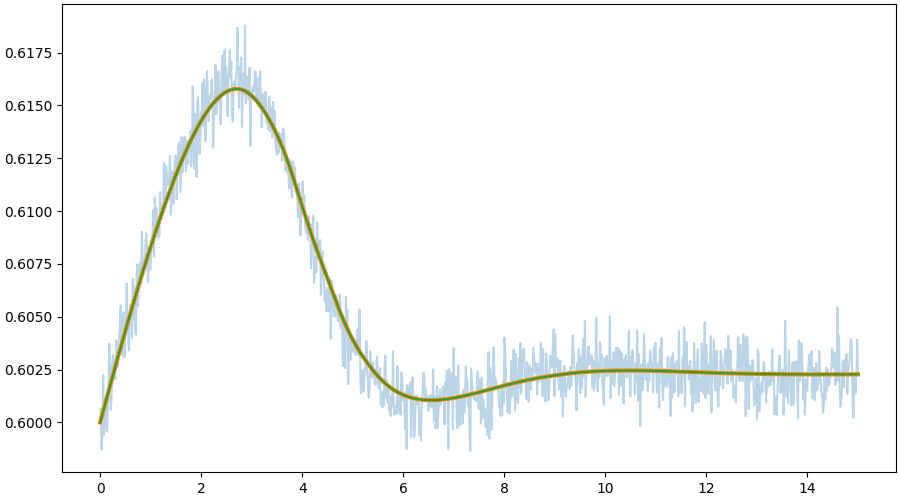

In [10]:
plt.close("all")
fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)
ax.plot(t, mu_measured, alpha=0.3)
ax.plot(t, result_predicted.mu, lw=3)
ax.plot(t, result_predicted2.mu)

Quantitative comparison:

In [11]:
print("\t\tInitial guess 1\tInversion 1\tInitial guess 2\tInversion 2\tTrue values")
print(f"a\t\t{params_guess.a:.2e}\t{params_inv.a:.2e}\t{params_guess2.a:.2e}\t{params_inv2.a:.2e}\t{params.a:.2e}")
print(f"b\t\t{params_guess.b:.2e}\t{params_inv.b:.2e}\t{params_guess2.b:.2e}\t{params_inv2.b:.2e}\t{params.b:.2e}")
print(f"Dc\t\t{params_guess.Dc:.2e}\t{params_inv.Dc:.2e}\t{params_guess2.Dc:.2e}\t{params_inv2.Dc:.2e}\t{params.Dc:.2e}")

		Initial guess 1	Inversion 1	Initial guess 2	Inversion 2	True values
a		1.10e-02	9.86e-03	9.00e-03	9.86e-03	1.00e-02
b		1.08e-02	8.87e-03	4.50e-03	8.87e-03	9.00e-03
Dc		5.00e-05	1.05e-05	2.00e-05	1.05e-05	1.00e-05


As you can see, the inversion for both initial guesses converged to the same final result. This is not a given, and results may vary depending on the level of noise and other factors, like slip weakening or other phenomena that are not accounted for by the friction model.

You can also see that the inverted parameters are not exactly the same as those that we started with. Because of the influence of the noise, this is not unexpected. But how "good" are the inverted results? Is the ~10% mismatch between the inversion and the ground truth acceptable, given the level of noise that we have? In other words, does the ground truth fall within the uncertainty of the inversion estimate? And are there other combinations of parameters that would also produce an acceptable fit to the observations?

These are the kind of questions that can be answered with Bayesian inversion.

## 3. Bayesian inversion

In [12]:
states = solver.bayesian_inversion(
    t=t, mu=mu_measured, noise_std=noise_amplitude, 
    params=params_inv, friction_constants=constants, 
    block_constants=block_constants, 
    Nparticles=100, Nsteps=100, key=42
)

TypeError: multiple values for argument 't'